In [1]:
import pyreadr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timeit

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import graphviz
from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
result = pyreadr.read_r('..\Maysv_hab.rds')
df = result[None]
df['Wetland'] = np.where(np.logical_or(df['Habitat']==1.0, df['Habitat']==2.0), 0, 1)

In [3]:
def XGBM(X, y, coords):
    fig, ax = plt.subplots()
    tree_axs = []
    
    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    Coordinates = pd.DataFrame(columns=['x', 'y'])

    feature_importances = pd.DataFrame()
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_coord = coords.iloc[train_index]
        test_coord = coords.iloc[test_index]

        model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        t_ax = plot_tree(model, orientation='horizontal')
        tree_axs.append(t_ax)
        
        feature_importance = model.feature_importances_
        rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[i])
        feature_importances = pd.concat([feature_importances, rel_imp], axis=1)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Coordinates = pd.merge(Coordinates, test_coord, on=['x', 'y'], how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Extreme Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
    feature_importances['mean'] = feature_importances.iloc[:, 0:5].mean(axis=1)
    
    output_df = pd.concat([Coordinates, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt, feature_importances['mean'], tree_axs

5it [00:01,  3.72it/s]


1.349438899999999 seconds
[0.5625, 0.75, 1.0, 0.8125, 0.8125]
0.7875 accuracy
[[45  8]
 [ 9 18]]
              precision    recall  f1-score   support

           0     0.8333    0.8491    0.8411        53
           1     0.6923    0.6667    0.6792        27

    accuracy                         0.7875        80
   macro avg     0.7628    0.7579    0.7602        80
weighted avg     0.7857    0.7875    0.7865        80

<module 'matplotlib.pyplot' from 'c:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


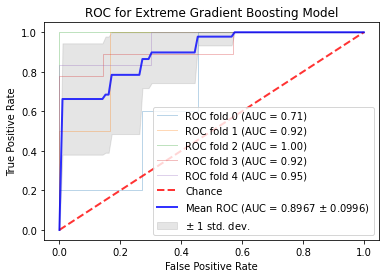

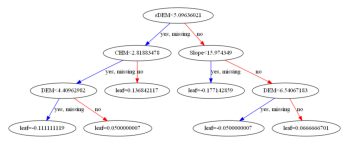

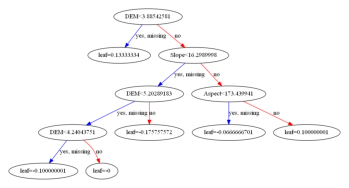

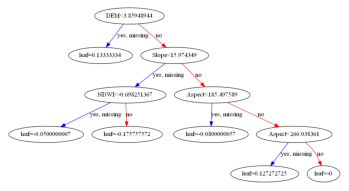

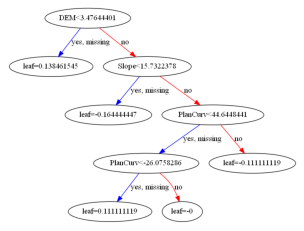

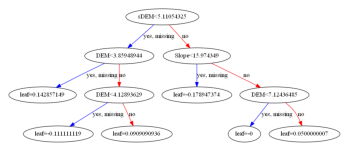

In [4]:
X = df.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y = df.Wetland
coords = df[['x', 'y']]
output_df, time, cm, cr, acc, roc, feat_imp, tree_axs = XGBM(X, y, coords)
print(f"{time} seconds")
print(f"{acc}")
print(f"{np.mean(acc)} accuracy")
print(cm)
print(cr)
print(roc)

Text(0.5, 1.0, 'XGM Variable Importance for Maysville')

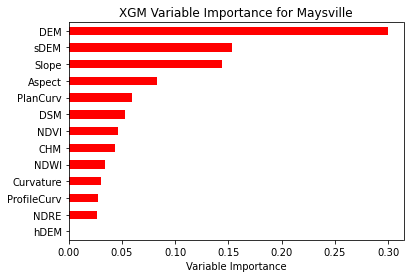

In [5]:
fig = feat_imp.sort_values()[-24:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("XGM Variable Importance for Maysville")

In [6]:
result = pyreadr.read_r('..\Maysv_all.rds')
df_all = result[None]

In [7]:
X_all = df_all.drop(['x', 'y', 'Habitat'], axis=1)
coords_all = df_all[['x', 'y']]

Coords = coords_all
Output = []

In [8]:
model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
model.fit(X, y)
pred_values = model.predict(X_all)
Output.extend(pred_values)

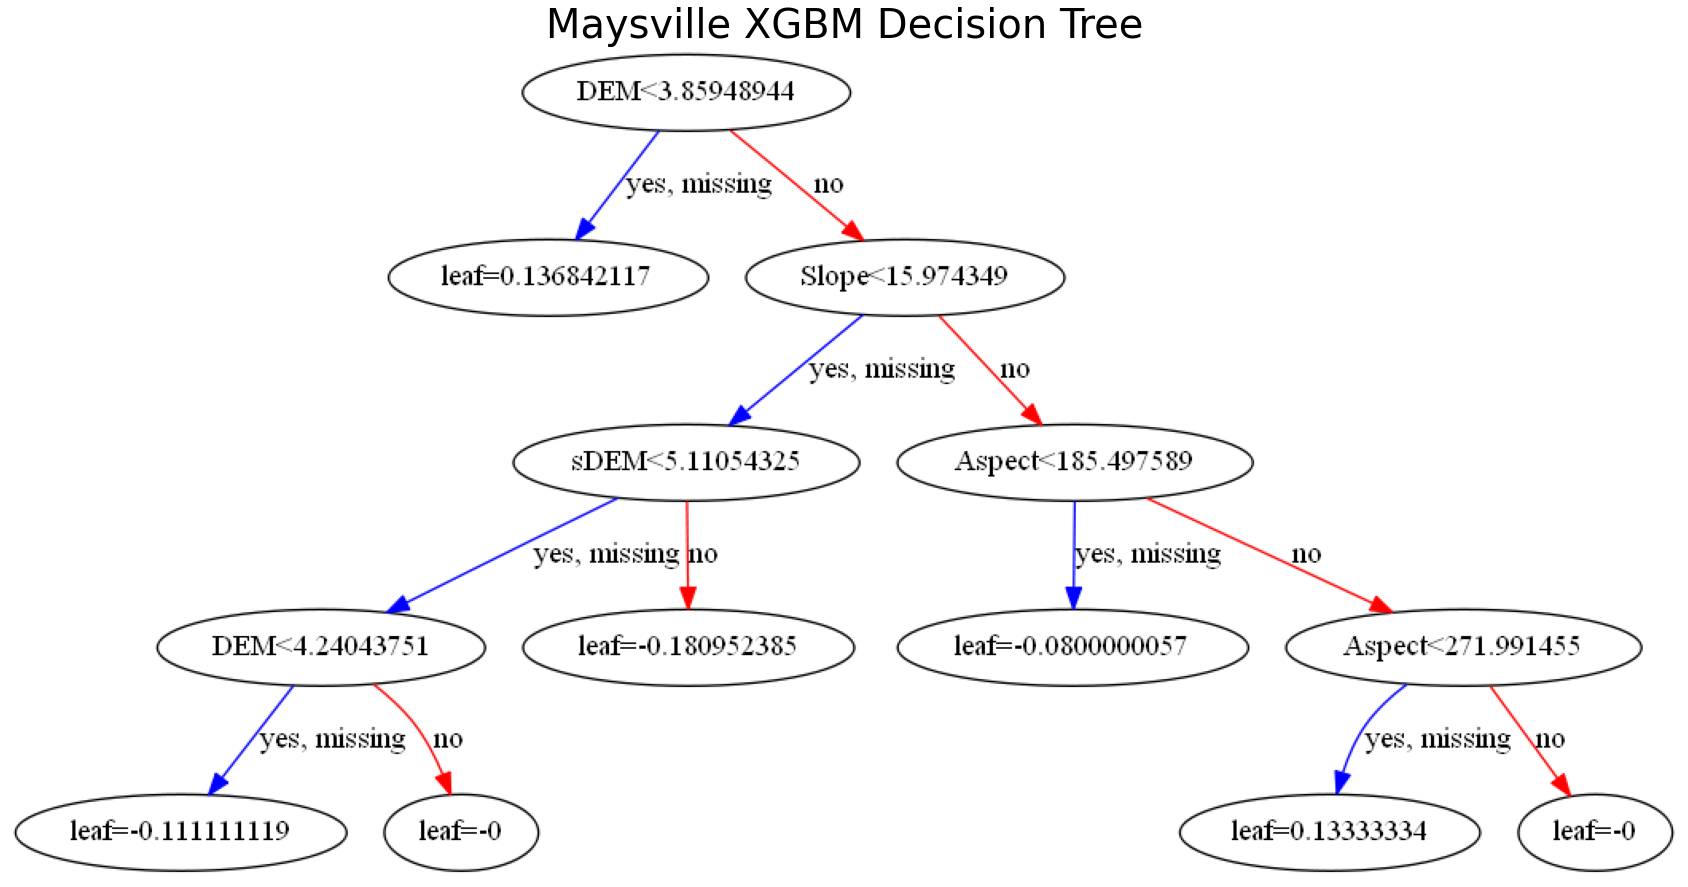

In [10]:
_, ax = plt.subplots(figsize=(30,30)) # Resize figure
plot_tree(model, filled=True, ax=ax, orientation='horizontal')
plt.title("Maysville XGBM Decision Tree", fontsize=40)
plt.savefig('test.png', dpi=300)

In [10]:
test_df = pd.concat([Coords, pd.DataFrame(Output, columns=["Output"])], axis=1)
test_df['Output'].value_counts()

0    1287362
1     683629
Name: Output, dtype: int64

In [11]:
test_df.to_csv("../Comparison Data/MaysvXGB.csv", index=False)